# Feature importance and feature interaction based on partial dependece variance

In this notebook example we will explain the global behavior of a regression model trained on a synthetic dataset. We will show how to compute the global feature attribution and the feature interactions for a given model.

We will follow the example from [Greenwell et al.]() on the Friedman's regression problem []().


In [1]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from alibi.explainers.pd_variance import PartialDependenceVariance, plot_pd_variance

%load_ext autoreload
%autoreload 2

### Friedman's regression problem

Friedman's regression problem introduced in [Friedman et al.]() and [Breiman et al.]() consists in predicting a target variable based on ten independent features sample from a Uniform(0, 1). Although the feature space consists of ten features only the first five of them appear in the true model. 

The relation between the input features and the response variables, $y$, is given by:

$$
y = 10 \sin(\pi x_1 x_2) + 20 (x_3 - 0.5)^2 + 10 x_4 + 5 x_5 + \epsilon
$$

where $x_i$, for $i=1, ..., 10$ are the ten input features, and $\epsilon \sim \mathcal{N}(0, \sigma^2)$.

In the following cell, we generate a dataset of 1000 examples which we split into 500 training examples and 500 testing examples. Similar to the paper setup, the simulated observation are generated using a $\sigma=1$. 

In [67]:
def generate_target(X: np.ndarray):
    """
    Generates the target/response variable for the Friedman's regression problem.
    
    Parameters
    ----------
    X
        A matrix realisations sampled from a Uniform(0, 1). The size of the matrix is `N x 10`,
        where `N` is the number of data instances.
    
    Returns
    -------
    Response variable.
    """
    return 10 * np.sin(np.pi * X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5)**2 \
        + 10 * X[:, 3] + 5 * X[:, 4] + np.random.randn(len(X))

np.random.seed(0)
X = np.random.rand(1000, 10)
y = generate_target(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

### Train MLP regressor

Similar with [Greenwell et al.], we train a Muti-layer Perceptron (MLP) regressor and report its score on both the train and test split. For the purposes of this examples, we keep the default configuration for the `MLPRegressor`.

In [68]:
# train MLP regressor on data
nn = MLPRegressor(max_iter=10000, random_state=0)
nn = nn.fit(X_train, y_train)

# compute score on train and test dataset
print("Train score: %.3f" % (nn.score(X_train, y_train)))
print("Test score: %.3f" % (nn.score(X_test, y_test)))

Train score: 0.968
Test score: 0.931


### Define explainer

Now that we have the prediction model, we can define the `PartialDependenceVariance` explainer to compute the feature importance and feature interactions.

Note that our explainer can work with any black-box model by providing the prediction function, which in our case will be `nn.predict`. Furthermore, we can specify the feature names and the target names to match our formulation through the parameters `feature_names` and `target_names`.

In [69]:
# define explainer
explainer = PartialDependenceVariance(predictor=nn.predict,
                                      feature_names=[f'x{i}' for i in range(1, 11)],
                                      target_names=['y'],
                                      verbose=True)

### Feature importance

With our explainer initialized, we can compute the feature importance for all feature through a simple call to the `explain` function. The arguments provided would be a reference dataset `X` which is usually the training dataset (i.e., `X_train` in our example) and setting `method='importance'`. Note that the `explain` function can receive many other arguments through which the user can specify explicitly the features to compute the feature importance for, the grid points (i.e., in our case `grid_resolution=50` to speed up the computation), etc. We refer the reader to our documentation page for further details.

In [70]:
exp_importance = explainer.explain(X=X_train,
                                   method='importance',
                                   grid_resolution=50)

100%|██████████| 10/10 [00:00<00:00, 33.26it/s]


Once our explanation is computed, we can visualize the feature importance in two ways. `Alibi` implements an utility plotting function, `plot_pd_variance`, which helps the user quickly visualize the results.

The simplest way and most straight forward way is to visualize the results through a horizontal bar plot. By default, the features are ordered in descending order by their importance from top to bottom. This can be achieved through as simple call to `plot_pd_variance` as follows:

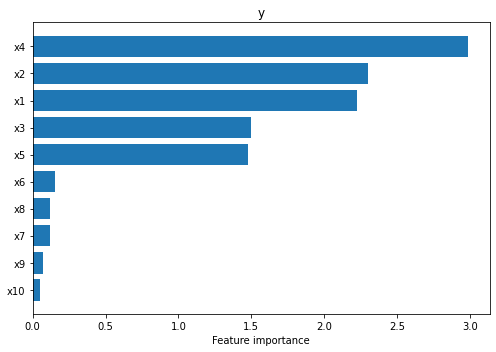

In [73]:
plot_pd_variance(exp=exp_importance,
                 features='all',
                 fig_kw={'figwidth': 7, 'figheight': 5});

We can see straight away that the explainer managed to identify that the first five features are the most salient (i.e., $x_4, x_2, x_1, x_3, x_5$ in decreasing order of their importance). 

As also recommended in the paper, the feature importance should be analyzed concomitantly with the partial dependence plots based on which the importance has been calculated. Our utility function allows the user to visualize the partial dependence plots by simply setting the parameter `summarise=False`. As before, the plots are sorted in descending order based on the corresponding feature importance.

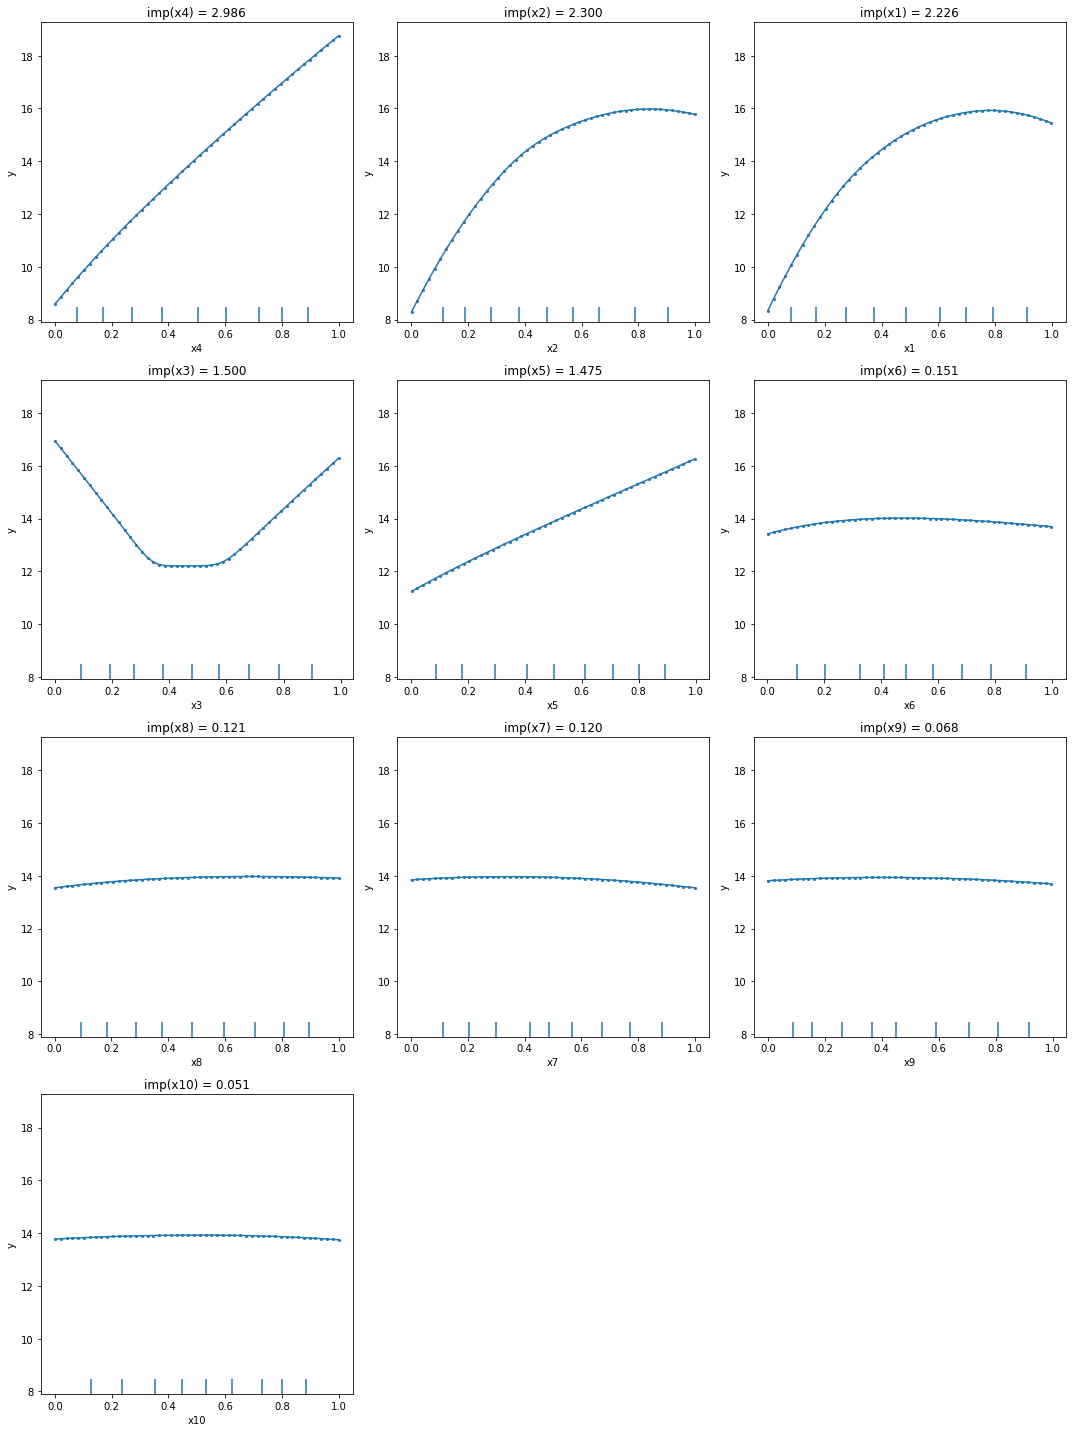

In [74]:
plot_pd_variance(exp=exp_importance,
                 features='all',
                 summarise=False,
                 n_cols=3,
                 fig_kw={'figwidth': 15, 'figheight': 20});

From the partial dependence plots, we can observe that the explainer managed to identify correctly the effects of each feature: linear for $x_4$ and $x_5$, quadratic for $x_3$, and sinusoidal for $x_1$ and $x_2$. The other variables show a relative flat main effect which according to the method's assumption means a low importance. Also, by inspecting the plots we can see that $x_4$ main effect spans a range from 8 to somewhere around 19, which is probably one of the reasons why it got the largest importance. 

### Feature interaction

As previously mentioned, the `PartialDependeceVariance` explainer is able to compute a measure of feature interaction. The call to the explainer follows the same API as above, just by simply calling the `explain` function with the parameter `method='interaction'`. By default, the explainer will compute a measure of interaction for all possible pairs of features. Note that this is quadratic in the number of features and is based on computing a two-ways partial dependence function for all pairs. Thus, this step might be more computational demanding. Similar with the computation of the feature importance, the user has the liberty to provide the features pairs for which the feature interaction will be computed and control the computation complexity through the grid parameters.

In [75]:
exp_interaction = explainer.explain(X=X_train,
                                    method='interaction',
                                    grid_resolution=30)

100%|██████████| 45/45 [00:21<00:00,  2.06it/s]


Once the explanation is computed, we can visualize the summary horizontal plot to identify the pairs of features that interact the most. Because the plot can grow very tall due to the quadratic number of feature pairs, we exposed the `top_k` parameter to limit the plot to the `top_k` most important features provided through the `features` parameter. In our case we set `top_k=10` and since `features='all'`, the plot will display the 10 feature pairs that interact the most out of all feature pairs.

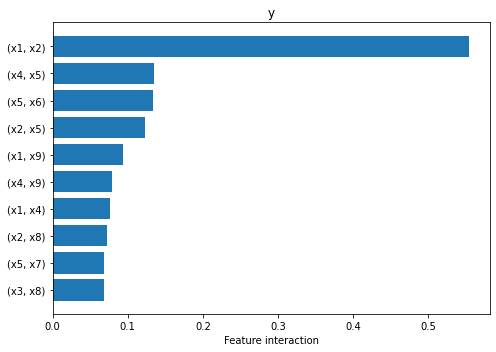

In [77]:
# plot summary
plot_pd_variance(exp=exp_interaction,
                 features='all',    # considers plotting all features
                 top_k=10,          # plots only the top 10 features from all the `features`
                 fig_kw={'figwidth': 7, 'figheight': 5});

We can observe that the explainer successfully managed to identify the $x_1$ and $x_2$ are the only features that interact through the function $\sin(\pi x_1 x_2)$.

As before, if we would like to visualize more details, we can call again the `plot_pd_variance` with `summarise=False`. For each explained feature pair the function will plot the two-way partial dependence plot followed immediately by two conditional importance plots, when conditioning on one feature at a time. Note that the final interaction between the two features is computed as the average of the two conditional interactions (see titles of each subplot). For visualization purposes, we recommend using `n_cols=3`, such that each row will describe only the feature interaction between one pair. Similar as before, the plots are displayed in descending order based on their interaction.

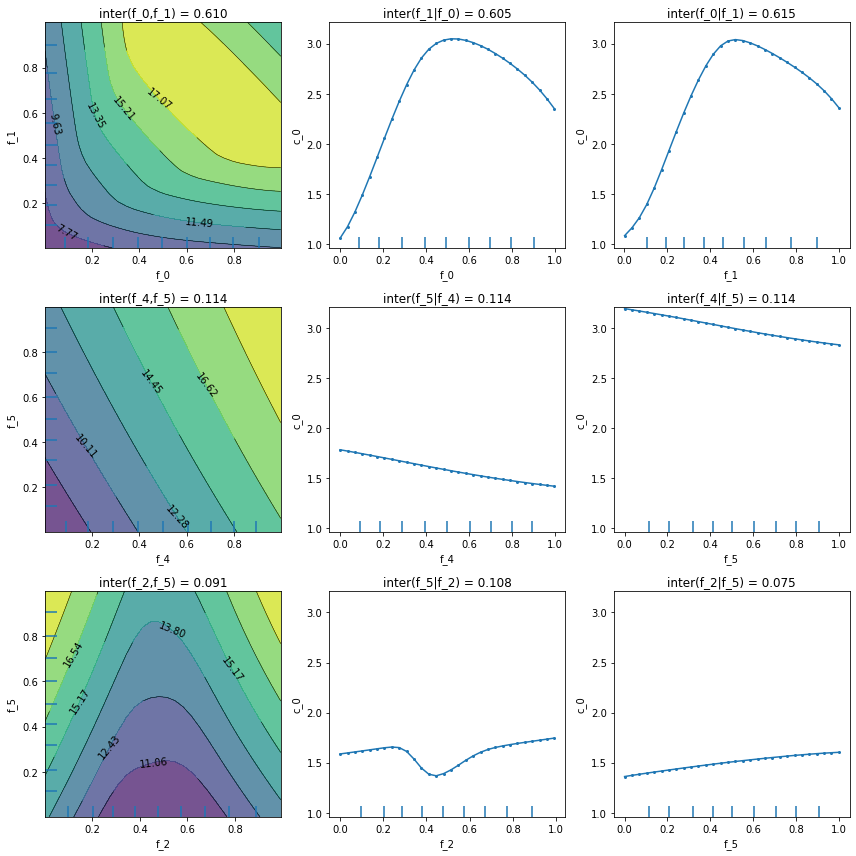

In [14]:
plot_pd_variance(exp=exp_interaction,
                 features='all',
                 top_k=3,
                 summarise=False,
                 n_cols=3,
                 fig_kw={'figwidth': 12, 'figheight': 12});